In [1]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [2]:
headers ={}
headers["user-agent"]= "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.131 Safari/537.36"
headers["Cookie"] = "laravel_session=eyJpdiI6IndaaUg1bGFhbjhOSEl4Z0tEditSR3c9PSIsInZhbHVlIjoiU2V3VmtlRldRYXJjSm04eVRxR2wxQW8xNTJaV0VwNCtEcGFlODNZRU1nVzhoRWxucmRoeTNnNVFMK0gxa3JoMFRhRGpiVHZHeXg1aWZNQVFZQmhubjBiZmhaMWZDd2RlRGdjdWxHeEhZYlp2VUVBeXQ4K3MxNUZRMWNNZlZ4NHQiLCJtYWMiOiIyMTQ0ZDZhNTI5OGU3NDA5OTk4NDk4MDMyZGE1ZDdiYzRkZTU4NjNlOGEzNWRlMjMxOTIzY2RhNzFhZjQ2NjRlIn0%3D"
URL = "https://nepsealpha.com/trading/1/history?symbol=AKPL&resolution=1D&from=1494288000&to=1628735188&currencyCode=NRS&pass=wmSqZ0ktvfWtuGVDljveTWlOU8YfGyx0QFz3Ackk"

resp = requests.get(URL, headers=headers)
raw_data = resp.json()

In [2]:
df = pd.read_json("testing.json")

In [3]:
df = df.drop('t', axis=1)
# df.corr()
# df.plot(subplots=True, layout=(6, 2), figsize=(24, 24))

In [4]:
df.tail()

,c,o,h,l,v
955,619.0,598.0,626.0,585.0,534026
956,631.0,631.0,637.0,617.1,507218
957,624.0,635.0,645.0,618.0,660814
958,685.0,630.0,686.0,630.0,840637
959,688.0,698.7,715.0,681.0,579592


In [176]:
from sklearn.preprocessing import MinMaxScaler

T = 21
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

x = df[['o', 'h', 'l', 'v']].copy()
y = df['c'].copy()

x = pd.DataFrame(x_scaler.fit_transform(x), columns=["open", "high", "low", "volume"])
y = pd.DataFrame(y_scaler.fit_transform(y.values.reshape(-1, 1)), columns=["close"])

x["close"] = y["close"]

In [177]:
#train_scaled.plot(subplots=True, figsize=(14, 14))
# print(f'{x.head(18)} {y.head(18)}')
# print(train_label.head(18))
y.iloc[1:3].values

array([[0.61002619],
       [0.59714965]])

In [178]:
def process_data(train_size, days):    
    X_train, Y_train = [], []
    for i in range(len(x) - (T+days)):
        X_train.append(x.iloc[i:i+T].values)
        Y_train.append(y.iloc[i+T:(i+T+days)].values.reshape(days))
    
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    
    split_size = int(train_size * X_train.shape[0])
    X_test, Y_test = X_train[split_size:], Y_train[split_size:]
    X_train, Y_train = X_train[:split_size], Y_train[:split_size]
    
    print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)
    return X_train, Y_train, X_test, Y_test

In [179]:
days = 10
X_train, Y_train, X_test, Y_test = process_data(0.9, days)

(836, 21, 5) (836, 10) (93, 21, 5) (93, 10)


In [180]:
model = Sequential()
model.add(LSTM(64, input_shape=(T, 5), return_sequences=True, activation='linear'))
model.add(BatchNormalization())
model.add(LSTM(units=32, return_sequences=True, activation='relu'))
model.add(BatchNormalization())
model.add(LSTM(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(days, activation='linear'))

model.compile(loss='mse', metrics=['accuracy'], optimizer='adam')
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 21, 64)            17920     
_________________________________________________________________
batch_normalization_14 (Batc (None, 21, 64)            256       
_________________________________________________________________
lstm_28 (LSTM)               (None, 21, 32)            12416     
_________________________________________________________________
batch_normalization_15 (Batc (None, 21, 32)            128       
_________________________________________________________________
lstm_29 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_18 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_19 (Dense)             (None, 10)               

In [181]:
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=50)

Epoch 1/50
27/27 [==============================] - 3s 30ms/step - loss: 0.0843 - accuracy: 0.0660 - val_loss: 0.2818 - val_accuracy: 0.1075
Epoch 2/50
27/27 [==============================] - 0s 16ms/step - loss: 0.0192 - accuracy: 0.0931 - val_loss: 0.2560 - val_accuracy: 0.0753
Epoch 3/50
27/27 [==============================] - 0s 16ms/step - loss: 0.0082 - accuracy: 0.1072 - val_loss: 0.2351 - val_accuracy: 0.1505
Epoch 4/50
27/27 [==============================] - 0s 17ms/step - loss: 0.0037 - accuracy: 0.0798 - val_loss: 0.2273 - val_accuracy: 0.1613
Epoch 5/50
27/27 [==============================] - 0s 16ms/step - loss: 0.0035 - accuracy: 0.1042 - val_loss: 0.2148 - val_accuracy: 0.1183
Epoch 6/50
27/27 [==============================] - 0s 16ms/step - loss: 0.0029 - accuracy: 0.0885 - val_loss: 0.2063 - val_accuracy: 0.1183
Epoch 7/50
27/27 [==============================] - 1s 19ms/step - loss: 0.0024 - accuracy: 0.1037 - val_loss: 0.1934 - val_accuracy: 0.0968
Epoch 8/50
27

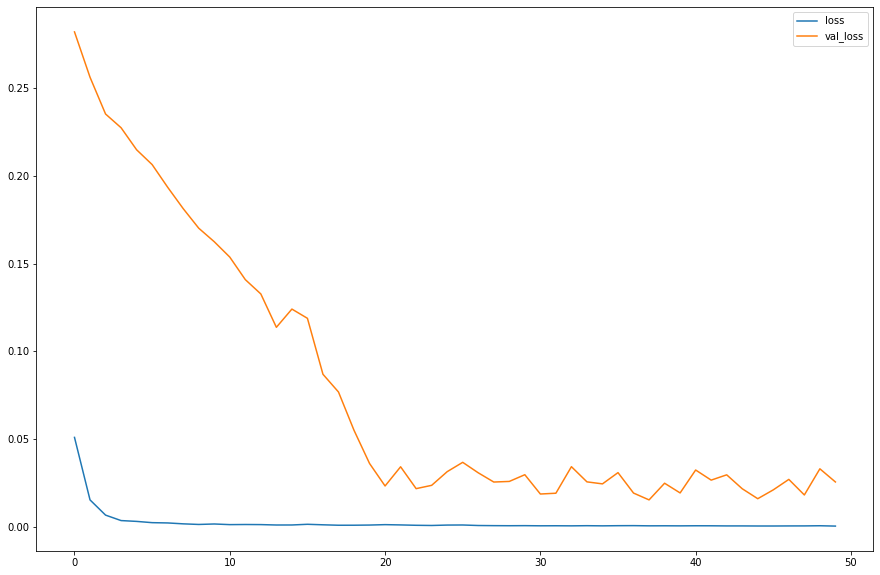

In [184]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure(figsize=(15, 10))
plt.plot(list(range(len(loss))), loss, label="loss")
plt.plot(list(range(len(loss))), val_loss, label="val_loss")
plt.legend(loc="best")

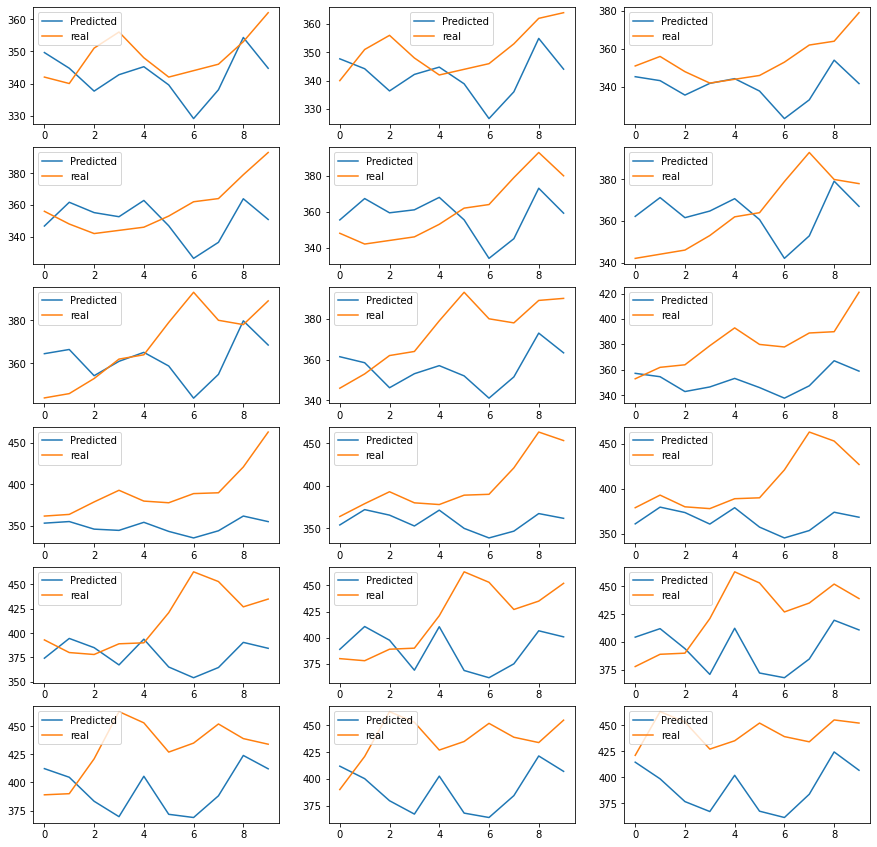

In [183]:
# print(y_scaler.inverse_transform(model.predict(X_train[1].reshape(-1, 14, 5))))
# print(y_scaler.inverse_transform([Y_train[1]]))
predicted = y_scaler.inverse_transform(model.predict(X_test))
real = y_scaler.inverse_transform(Y_test)

pos = 30
# print(predicted[pos], real[pos])

fig, ax = plt.subplots(6, 3, figsize=(15, 15))
sum = 0
for i in range(6):
    for j in range(3):
        ax[i][j].plot(predicted[pos+sum], label="Predicted")
        ax[i][j].plot(real[pos+sum], label="real")
        sum = sum + 1
        ax[i][j].legend(loc='best')

In [103]:
model.save("umhlmodel_3days.h5")

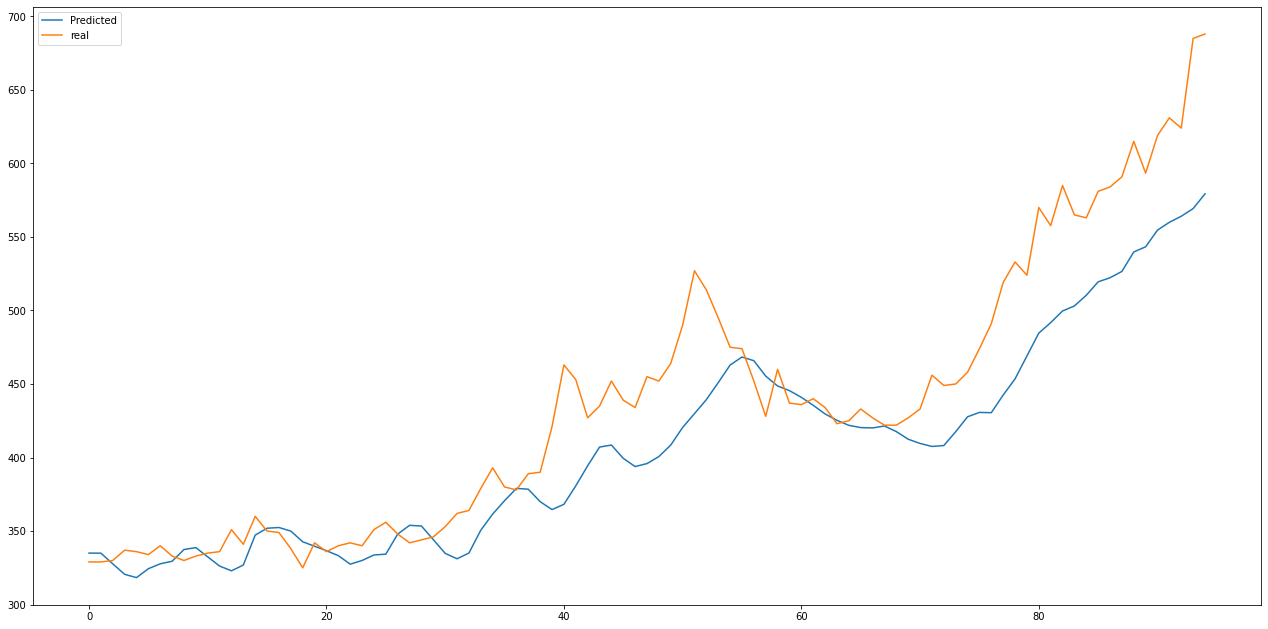

In [259]:
first = X_test[0].reshape(-1, 14, 5)

predictions = []
for i in range(Y_test.shape[0]):
    predictions.append(model.predict(first)[0][0])
    first = np.delete(first[0], 0, axis=0)
    second = np.append(X_test[i][-1][:-1], predictions[i])
    first = np.append(first, [second], axis=0)
    first = first.reshape(-1, 14, 5)

predictions = y_scaler.inverse_transform(np.array(predictions).reshape(Y_test.shape[0], -1))
x_axis = list(range(Y_test.shape[0]))
plt.figure(figsize=(22, 11))
# plt.grid()
plt.xscale('linear')
plt.plot(x_axis, predictions, label="Predicted")
plt.plot(x_axis, real, label="real")
plt.legend(loc='best')
plt.show()

In [249]:
print(metrics.mean_squared_error(predictions, real) ** .5)
print(metrics.mean_squared_error(predicted, real) ** .5)

43.09372096768025
30.714613945982176


In [43]:
from tensorflow.keras.models import load_model

model = load_model('umhlmodel.h5')
predicted_val = y_scaler.inverse_transform(
    model.predict(
        X_test[94].reshape(-1, 14, 5)
    )
)

print('predicted value: ', predicted_val)
print('true value: ', y_scaler.inverse_transform(Y_test[94].reshape(1, -1)))
# x_scaler.transform()
y_scaler.inverse_transform(
    model.predict(
        np.append(X_test[-1][1:], [x.iloc[-1]], axis=0).reshape(-1, 14, 5)
    )
)

predicted value:  [[610.20636]]
true value:  [[688.]]


array([[620.96576]], dtype=float32)